# Mental Health Datathon – MTherapy

학생·직장인 정신건강 위험도 예측 및 **보호효과(Protection Effect)** 기반 개입 시나리오 분석

1. 문제 정의 & 데이터 개요  
2. EDA: 주요 위험 요인 탐색  
3. 예측 모델 구축(XGBoost) 및 성능 평가  
4. 정책 개입 시나리오 정의  
5. 개입 시나리오 시뮬레이션 및 보호효과(PE) 계산  
6. 결과 시각화 및 정책 제안 요약


## 1. 라이브러리 임포트

In [2]:
# 기본 분석/시각화 라이브러리
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# 머신러닝 관련
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    accuracy_score,
    roc_auc_score,
    classification_report,
    confusion_matrix,
)

from xgboost import XGBClassifier

# 그래프 기본 설정
plt.rcParams["figure.figsize"] = (7, 4)
plt.rcParams["font.size"] = 10
plt.rcParams["axes.unicode_minus"] = False  # 마이너스 깨짐 방지

def save_or_show(title=None, fname=None):
    """
    공통 그래프 helper
    - title 이 있으면 그래프 제목 설정
    - fname 이 있으면 해당 파일명으로 저장 (발표용 이미지)
    """
    if title:
        plt.title(title)
    plt.tight_layout()
    if fname:
        plt.savefig(fname, dpi=150, bbox_inches="tight")
    plt.show()

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## 2. 데이터 로드 & 기본 구조 확인

In [4]:
# ※ train.csv, test.csv 가 같은 폴더(코랩이라면 /content)에 있다고 가정합니다.
train_path = "/content/drive/MyDrive/SQL_modu/1126_datathon/train.csv"
test_path  = "/content/drive/MyDrive/SQL_modu/1126_datathon/train.csv"

train = pd.read_csv(train_path)
test = pd.read_csv(test_path)

TARGET = "Depression"
ID_COLS = ["id", "Name"]  # ID/식별자 컬럼 (필요시 수정)

print("train shape:", train.shape)
print("test  shape:", test.shape)
print("columns:", list(train.columns))

train.head()

train shape: (140700, 20)
test  shape: (140700, 20)
columns: ['id', 'Name', 'Gender', 'Age', 'City', 'Working Professional or Student', 'Profession', 'Academic Pressure', 'Work Pressure', 'CGPA', 'Study Satisfaction', 'Job Satisfaction', 'Sleep Duration', 'Dietary Habits', 'Degree', 'Have you ever had suicidal thoughts ?', 'Work/Study Hours', 'Financial Stress', 'Family History of Mental Illness', 'Depression']


,id,Name,Gender,Age,City,Working Professional or Student,Profession,Academic Pressure,Work Pressure,CGPA,Study Satisfaction,Job Satisfaction,Sleep Duration,Dietary Habits,Degree,Have you ever had suicidal thoughts ?,Work/Study Hours,Financial Stress,Family History of Mental Illness,Depression
0,0,Aaradhya,Female,49.0,Ludhiana,Working Professional,Chef,NaN,5.0,NaN,NaN,2.0,More than 8 hours,Healthy,BHM,No,1.0,2.0,No,0
1,1,Vivan,Male,26.0,Varanasi,Working Professional,Teacher,NaN,4.0,NaN,NaN,3.0,Less than 5 hours,Unhealthy,LLB,Yes,7.0,3.0,No,1
2,2,Yuvraj,Male,33.0,Visakhapatnam,Student,NaN,5.0,NaN,8.97,2.0,NaN,5-6 hours,Healthy,B.Pharm,Yes,3.0,1.0,No,1
3,3,Yuvraj,Male,22.0,Mumbai,Working Professional,Teacher,NaN,5.0,NaN,NaN,1.0,Less than 5 hours,Moderate,BBA,Yes,10.0,1.0,Yes,1
4,4,Rhea,Female,30.0,Kanpur,Working Professional,Business Analyst,NaN,1.0,NaN,NaN,1.0,5-6 hours,Unhealthy,BBA,Yes,9.0,4.0,Yes,0


## 3. EDA – 타깃 분포 및 주요 그룹 비교

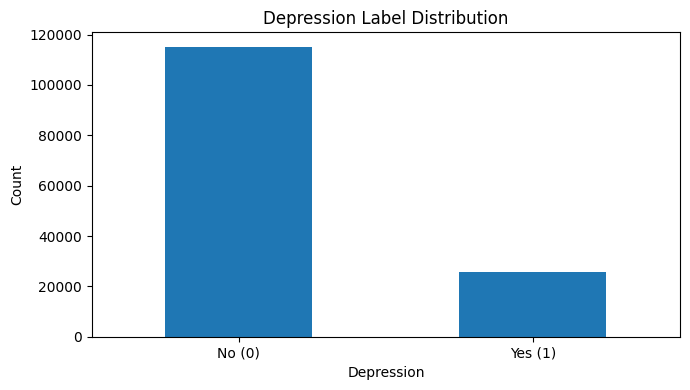

(Depression
 0    115133
 1     25567
 Name: count, dtype: int64,
 Depression
 0    81.828714
 1    18.171286
 Name: count, dtype: float64)

In [5]:
# 3-1. 타깃(Depression) 분포 확인
counts = train[TARGET].value_counts().sort_index()

plt.figure()
counts.plot(kind="bar")
plt.xticks([0, 1], ["No (0)", "Yes (1)"], rotation=0)
plt.ylabel("Count")
save_or_show("Depression Label Distribution", "fig1_target_dist.png")

counts, counts / counts.sum() * 100

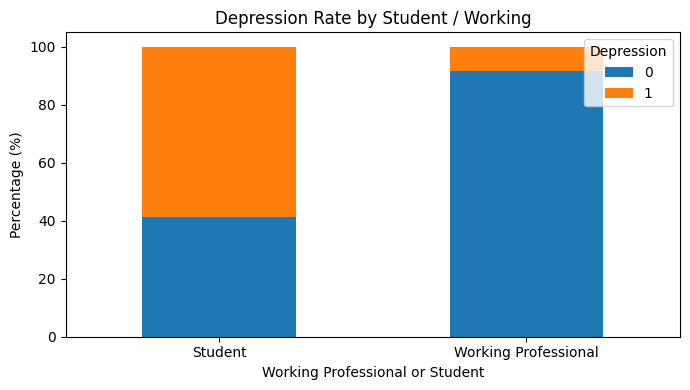

Depression,0,1
Working Professional or Student,,
Student,41.450127,58.549873
Working Professional,91.816417,8.183583


In [6]:
# 3-2. 학생 vs 직장인 그룹별 우울 비율 (발표용 stacked bar)

group_col = "Working Professional or Student"  # 필요시 컬럼명 확인/수정
cross = pd.crosstab(train[group_col], train[TARGET], normalize="index") * 100

plt.figure()
cross.plot(kind="bar", stacked=True, ax=plt.gca())
plt.ylabel("Percentage (%)")
plt.legend(title="Depression", loc="upper right")
plt.xticks(rotation=0)
save_or_show("Depression Rate by Student / Working",
             "fig2_student_worker.png")

cross

## 4. EDA – 주요 위험 요인 (Financial Stress, Sleep, Academic Pressure 등)

핵심 위험요인은 다음과 같이 설정합니다.

- **Financial Stress**
- **Sleep Duration**
- **Academic Pressure**
- **Work/Study Hours**

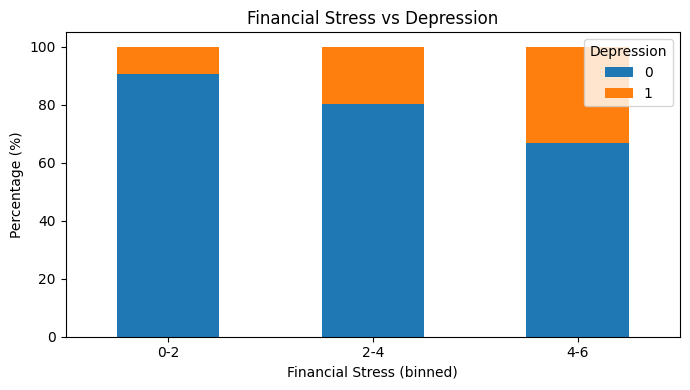

Depression,0,1
Financial Stress,,
0-2,90.620845,9.379155
2-4,80.204632,19.795368
4-6,66.678454,33.321546


In [7]:
# 4-1. Financial Stress vs Depression (binned + stacked bar)

bins = [0, 2, 4, 6, 8, 10]
labels = ["0-2", "2-4", "4-6", "6-8", "8-10"]
fs_bin = pd.cut(train["Financial Stress"], bins=bins, labels=labels, include_lowest=True)

fs_cross = pd.crosstab(fs_bin, train[TARGET], normalize="index") * 100

plt.figure()
fs_cross.plot(kind="bar", stacked=True, ax=plt.gca())
plt.ylabel("Percentage (%)")
plt.xlabel("Financial Stress (binned)")
plt.legend(title="Depression")
plt.xticks(rotation=0)
save_or_show("Financial Stress vs Depression",
             "fig3_financial_stress_dep.png")

fs_cross

Sleep Duration
Less than 5 hours    38784
7-8 hours            36969
More than 8 hours    32726
5-6 hours            32142
3-4 hours               12
6-7 hours                8
4-5 hours                7
4-6 hours                5
2-3 hours                5
6-8 hours                4
No                       4
1-6 hours                4
10-11 hours              2
9-11 hours               2
8-9 hours                2
Sleep_Duration           2
Unhealthy                2
45                       2
40-45 hours              1
1-2 hours                1
1-3 hours                1
9-6 hours                1
55-66 hours              1
Moderate                 1
35-36 hours              1
8 hours                  1
10-6 hours               1
Indore                   1
than 5 hours             1
49 hours                 1
Work_Study_Hours         1
3-6 hours                1
45-48 hours              1
9-5                      1
Pune                     1
9-5 hours                1
Name: count, 

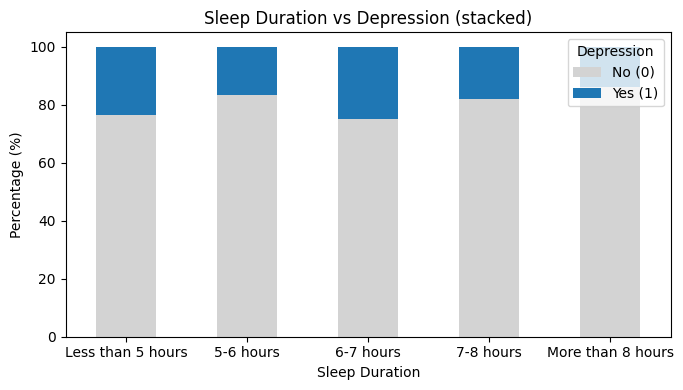

Depression,0,1
Sleep Duration,,
Less than 5 hours,76.534138,23.465862
5-6 hours,83.442225,16.557775
6-7 hours,75.000000,25.000000
7-8 hours,82.166139,17.833861
More than 8 hours,86.130294,13.869706


In [8]:
# 4-2. Sleep Duration vs Depression (가독성 높은 stacked bar)

col = "Sleep Duration"
print(train[col].value_counts())

sleep_order = [
    "Less than 5 hours",
    "5-6 hours",
    "6-7 hours",
    "7-8 hours",
    "More than 8 hours",
]
sleep_order = [c for c in sleep_order if c in train[col].unique()]

sleep_cross = (
    pd.crosstab(train[col], train[TARGET], normalize="index") * 100
).reindex(sleep_order)

plt.figure(figsize=(7, 4))
sleep_cross = sleep_cross[[0, 1]]  # 0,1 순서 고정

sleep_cross.plot(
    kind="bar",
    stacked=True,
    ax=plt.gca(),
    color=["lightgray", "tab:blue"],  # 0=회색, 1=파랑
)

plt.ylabel("Percentage (%)")
plt.xlabel("Sleep Duration")
plt.legend(title="Depression", labels=["No (0)", "Yes (1)"], loc="upper right")
plt.xticks(rotation=0)
save_or_show("Sleep Duration vs Depression (stacked)",
             "fig4_sleep_dep_stacked.png")

sleep_cross

## 5. 예측 모델 구축 – XGBoost 분류기

In [9]:
# 5-1. Feature / Target 분리
exclude_cols = ID_COLS + [TARGET]
feature_cols = [c for c in train.columns if c not in exclude_cols]

X = train[feature_cols].copy()
y = train[TARGET].copy()

# 5-2. 학습/검증 데이터 분리
X_train, X_valid, y_train, y_valid = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# 5-3. 숫자/범주형 컬럼 분리
numeric_features = X.select_dtypes(include=[np.number]).columns.tolist()
categorical_features = X.select_dtypes(exclude=[np.number]).columns.tolist()

print("numeric_features:", numeric_features)
print("categorical_features:", categorical_features)

numeric_features: ['Age', 'Academic Pressure', 'Work Pressure', 'CGPA', 'Study Satisfaction', 'Job Satisfaction', 'Work/Study Hours', 'Financial Stress']
categorical_features: ['Gender', 'City', 'Working Professional or Student', 'Profession', 'Sleep Duration', 'Dietary Habits', 'Degree', 'Have you ever had suicidal thoughts ?', 'Family History of Mental Illness']


In [10]:
# 5-4. 전처리 파이프라인 정의

numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
])

categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("encoder", OneHotEncoder(handle_unknown="ignore")),
])

preprocess = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features),
    ]
)

# 5-5. XGBoost 분류 모델 정의
pos_weight = (len(y_train) - y_train.sum()) / y_train.sum()

model = XGBClassifier(
    n_estimators=400,
    max_depth=5,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    eval_metric="logloss",
    n_jobs=-1,
    scale_pos_weight=pos_weight,
    random_state=42,
)

xgb_clf = Pipeline(steps=[
    ("preprocess", preprocess),
    ("model", model),
])

# 5-6. 학습
xgb_clf.fit(X_train, y_train)

Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median'))]),
                                                  ['Age', 'Academic Pressure',
                                                   'Work Pressure', 'CGPA',
                                                   'Study Satisfaction',
                                                   'Job Satisfaction',
                                                   'Work/Study Hours',
                                                   'Financial Stress']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('encoder',
                                                                   OneHotEn...
                               feature_types=None, feature_weights=None,
                               gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=0.05,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=5, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=400, n_jobs=-1,
                               num_parallel_tree=None, ...))])

In [11]:
# 5-7. 검증 데이터 성능 평가

y_pred = xgb_clf.predict(X_valid)
y_proba = xgb_clf.predict_proba(X_valid)[:, 1]

print("[Validation Performance]\n")
print(classification_report(y_valid, y_pred))
print("ROC-AUC:", roc_auc_score(y_valid, y_proba))

[Validation Performance]

              precision    recall  f1-score   support

           0       0.98      0.92      0.95     23027
           1       0.71      0.92      0.80      5113

    accuracy                           0.92     28140
   macro avg       0.85      0.92      0.88     28140
weighted avg       0.93      0.92      0.92     28140

ROC-AUC: 0.9741010924420045


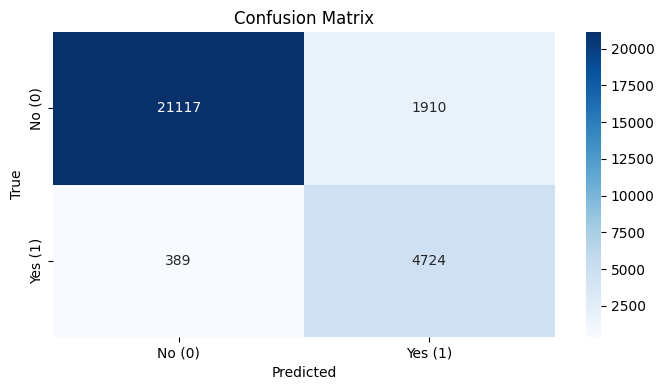

array([[21117,  1910],
       [  389,  4724]])

In [12]:
# 5-8. Confusion Matrix 시각화

cm = confusion_matrix(y_valid, y_pred)
labels = ["No (0)", "Yes (1)"]

plt.figure()
sns.heatmap(cm, annot=True, fmt="d",
            xticklabels=labels, yticklabels=labels, cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("True")
save_or_show("Confusion Matrix", "fig5_confusion_matrix.png")

cm

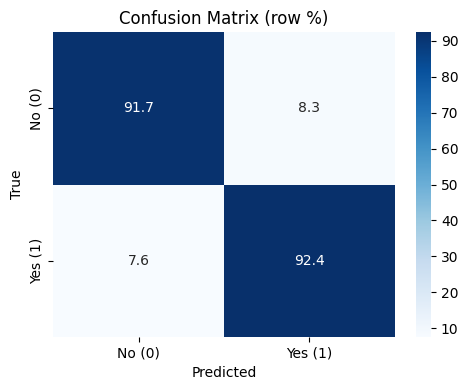

array([[91.70538933,  8.29461067],
       [ 7.60805789, 92.39194211]])

In [13]:
from sklearn.metrics import confusion_matrix, classification_report

# 기존
cm = confusion_matrix(y_valid, y_pred)
labels = ["No (0)", "Yes (1)"]

# 🔹 행 기준(실제 클래스 기준) 퍼센트로 변환
cm_norm = cm / cm.sum(axis=1, keepdims=True)  # 각 행 합이 1이 되도록
cm_norm_perc = cm_norm * 100

plt.figure(figsize=(5, 4))
sns.heatmap(
    cm_norm_perc,
    annot=True,
    fmt=".1f",
    xticklabels=labels,
    yticklabels=labels,
    cmap="Blues"
)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix (row %)")
save_or_show(None, "fig5_confusion_matrix_percent.png")

cm_norm_perc


## 6. 전체 학습 및 예측 결과 생성

In [14]:
# 6-1. 전체 train 데이터로 재학습
xgb_clf.fit(X, y)

# 6-2. test 데이터 feature 구성
X_test = test[feature_cols].copy()

# 6-3. 예측 (확률 + 라벨)
test_pred_proba = xgb_clf.predict_proba(X_test)[:, 1]
test_pred = (test_pred_proba >= 0.5).astype(int)  # threshold 필요시 조정 가능

# 6-4. 예시 제출 파일 생성
submission = pd.DataFrame({
    "id": test["id"],
    "Depression": test_pred,
})
submission.to_csv("submission_example.csv", index=False)
submission.head()

,id,Depression
0,0,0
1,1,1
2,2,1
3,3,1
4,4,1


In [16]:
# -------------------------------------------------
# 1) all_feature_names, importances 는 이미 앞에서 만든 것 사용
#    (numeric + one-hot 모두 포함된 이름과 중요도)
# -------------------------------------------------

orig_names = []
for name in all_feature_names:
    # OneHotEncoder는 "컬럼명_카테고리" 형식으로 이름을 만듦
    # 예: "Working Professional or Student_Student"
    if "_" in name and name not in numeric_features:
        # 마지막 '_' 앞까지를 원래 컬럼명으로 취급
        orig = name.rsplit("_", 1)[0]
    else:
        orig = name
    orig_names.append(orig)

fi_orig = pd.DataFrame({
    "orig_feature": orig_names,
    "importance": importances
})

# 같은 원본 컬럼에 해당하는 중요도들을 합산
fi_orig_grouped = (
    fi_orig
    .groupby("orig_feature", as_index=False)["importance"]
    .sum()
    .sort_values("importance", ascending=False)
)

# 상위 N개만 보기
top_n = 15
fi_orig_top = fi_orig_grouped.head(top_n)
fi_orig_top


NameError: name 'all_feature_names' is not defined

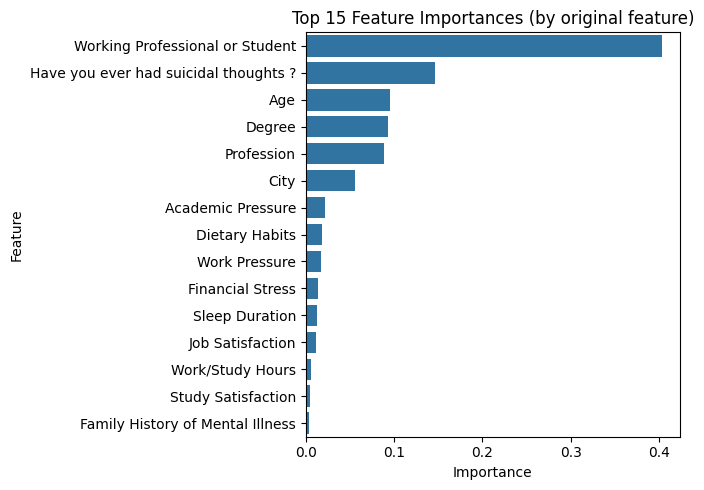

In [17]:
# -------------------------------------------------
# 2) 원래 컬럼 기준 Feature Importance 바차트
# -------------------------------------------------
plt.figure(figsize=(7, 5))
sns.barplot(
    data=fi_orig_top,
    x="importance",
    y="orig_feature"
)
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.title(f"Top {top_n} Feature Importances (by original feature)")
plt.tight_layout()
plt.savefig("fig_feature_importance_orig_top15.png", dpi=150, bbox_inches="tight")
plt.show()


## 7. 정책 개입 시나리오 정의

세 가지 정책 개입 시나리오를 데이터 Feature와 연결하여 설정합니다.

1. **장학·재정 지원** → Financial Stress 감소  
2. **수면 교육** → Sleep Duration 개선  
3. **상담·스트레스 완화 패키지** → Academic Pressure & Work/Study Hours 완화
4. **영양, 급식 개선** → Dietary Habits --> healthy



In [18]:
# 7-1. 기본 위험도(W_base) = 현재 상태 기준 우울 확률
W_base = xgb_clf.predict_proba(X)[:, 1]
train["W_base"] = W_base

# 7-2. 시나리오 1: 장학·재정 지원
#      (Financial Stress 상위 30%  → 30% 감소)
scenario_fs = X.copy()
q70_fs = scenario_fs["Financial Stress"].quantile(0.7)
mask_fs_high = scenario_fs["Financial Stress"] >= q70_fs

scenario_fs.loc[mask_fs_high, "Financial Stress"] *= 0.7
W_fs = xgb_clf.predict_proba(scenario_fs)[:, 1]
train["W_fs"] = W_fs

# 7-3. 시나리오 2: 수면 교육
#      (6시간 미만 수면 학생 → "7-8 hours"로 조정)
scenario_sleep = X.copy()
short_sleep_cats = ["Less than 5 hours", "5-6 hours"]
mask_sleep_short = scenario_sleep["Sleep Duration"].isin(short_sleep_cats)

if "7-8 hours" in scenario_sleep["Sleep Duration"].unique():
    scenario_sleep.loc[mask_sleep_short, "Sleep Duration"] = "7-8 hours"

W_sleep = xgb_clf.predict_proba(scenario_sleep)[:, 1]
train["W_sleep"] = W_sleep

# 7-4. 시나리오 3: 상담·스트레스 완화
#      (학업압박 상위 30% → AP 20%↓, Work/Study Hours 10%↓)
scenario_stress = X.copy()
q70_acad = scenario_stress["Academic Pressure"].quantile(0.7)
mask_high_acad = scenario_stress["Academic Pressure"] >= q70_acad

scenario_stress.loc[mask_high_acad, "Academic Pressure"] *= 0.8   # 20% 감소
scenario_stress.loc[mask_high_acad, "Work/Study Hours"] *= 0.9    # 10% 감소

W_stress = xgb_clf.predict_proba(scenario_stress)[:, 1]
train["W_stress"] = W_stress

# 7-5. 시나리오 4: 영양·급식 개선
#      (Dietary Habits == "Unhealthy" → "Healthy"로 전환)
scenario_nutri = X.copy()
mask_unhealthy = scenario_nutri["Dietary Habits"] == "Unhealthy"

if "Healthy" in scenario_nutri["Dietary Habits"].unique():
    scenario_nutri.loc[mask_unhealthy, "Dietary Habits"] = "Healthy"

W_nutri = xgb_clf.predict_proba(scenario_nutri)[:, 1]
train["W_nutri"] = W_nutri


In [ ]:
"""
W_base : 현재 상태 위험도
W_fs : 재정지원 시나리오 위험도
W_sleep : 수면교육 시나리오 위험도
W_stress : 상담·스트레스 시나리오 위험도
W_nutri : 급식·영양 개선 시나리오 위험도

"""

## 8. 보호효과(Protection Effect) 계산 및 시각화 테스트

In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# ----------------------------------------
# 1) 보호효과(Protection Effect) 계산 함수
# ----------------------------------------
def compute_pe(df, base_col, scen_col):
    """
    df: DataFrame (train)
    base_col: 기준 위험도 컬럼명 (ex: 'W_base')
    scen_col: 시나리오 적용 후 위험도 컬럼명 (ex: 'W_fs')

    반환값:
      - base_mean: 기준 위험도 평균
      - scen_mean: 시나리오 위험도 평균
      - pe: 보호효과 (%), 클수록 좋음 (위험 감소율)
    """
    base_mean = df[base_col].mean()
    scen_mean = df[scen_col].mean()

    if base_mean == 0:
        pe = np.nan
    else:
        pe = (base_mean - scen_mean) / base_mean * 100

    return base_mean, scen_mean, pe


# ----------------------------------------
# 2) 네 가지 시나리오에 대해 PE 계산
# ----------------------------------------
scenario_defs = [
    ("Financial Aid (FS↓30%)",   "W_fs"),
    ("Sleep Education",          "W_sleep"),
    ("Stress Counseling",        "W_stress"),
    ("Nutrition Program",        "W_nutri"),
]

rows = []
for name, col in scenario_defs:
    base_mean, scen_mean, pe = compute_pe(train, "W_base", col)
    rows.append({
        "scenario": name,
        "base_mean": base_mean,
        "scenario_mean": scen_mean,
        "PE(%)": pe
    })

pe_df = pd.DataFrame(rows)
pe_df


,scenario,base_mean,scenario_mean,PE(%)
0,Financial Aid (FS↓30%),0.24994,0.226716,9.292161
1,Sleep Education,0.24994,0.243118,2.729739
2,Stress Counseling,0.24994,0.245101,1.936128
3,Nutrition Program,0.24994,0.232165,7.111785


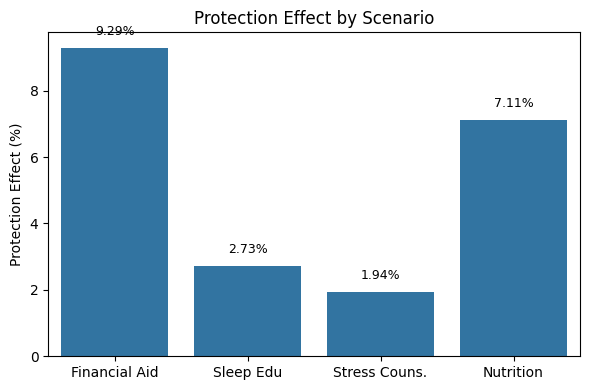

,scenario,PE(%)
0,Financial Aid (FS↓30%),9.292161
1,Sleep Education,2.729739
2,Stress Counseling,1.936128
3,Nutrition Program,7.111785


In [20]:
# 시각화용으로 짧은 레이블 컬럼 생성
plot_df = pe_df.copy()
plot_df["scenario_short"] = [
    "Financial Aid",
    "Sleep Edu",
    "Stress Couns.",
    "Nutrition",
]

plt.figure(figsize=(6, 4))
sns.barplot(data=plot_df, x="scenario_short", y="PE(%)")
plt.ylabel("Protection Effect (%)")
plt.xlabel("")
plt.title("Protection Effect by Scenario")

# 막대 위에 수치 표시
for i, v in enumerate(plot_df["PE(%)"]):
    if pd.notna(v):
        plt.text(i, v + 0.3, f"{v:.2f}%", ha="center", va="bottom", fontsize=9)

plt.tight_layout()
plt.savefig("fig_pe_summary_4scenarios.png", dpi=150, bbox_inches="tight")
plt.show()

plot_df[["scenario", "PE(%)"]]


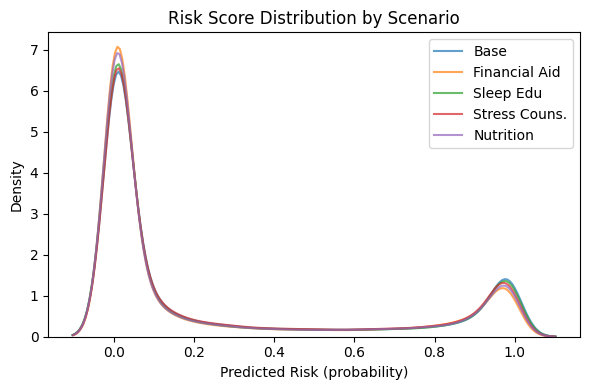

In [23]:
# 평균만 보는 게 아니라, 분포 자체가 어떻게 이동했는지” 보여주고
plt.figure(figsize=(6,4))

for col, label in [
    ("W_base",   "Base"),
    ("W_fs",     "Financial Aid"),
    ("W_sleep",  "Sleep Edu"),
    ("W_stress", "Stress Couns."),
    ("W_nutri",  "Nutrition"),
]:
    sns.kdeplot(train[col], label=label, alpha=0.7)

plt.xlabel("Predicted Risk (probability)")
plt.ylabel("Density")
plt.title("Risk Score Distribution by Scenario")
plt.legend()
plt.tight_layout()
plt.savefig("fig_wscore_shift_all.png", dpi=150, bbox_inches="tight")
plt.show()


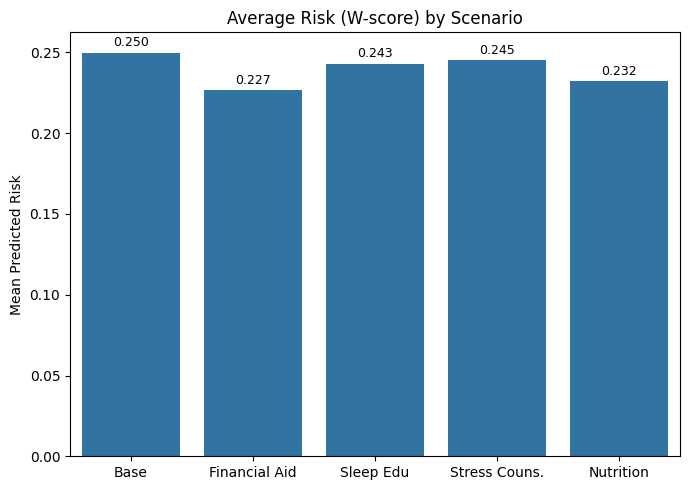

In [25]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

mean_df = pd.DataFrame({
    "Scenario": ["Base", "Financial Aid", "Sleep Edu", "Stress Couns.", "Nutrition"],
    "Mean_Risk": [
        train["W_base"].mean(),
        train["W_fs"].mean(),
        train["W_sleep"].mean(),
        train["W_stress"].mean(),
        train["W_nutri"].mean(),   # ← 여기 W_nutri
    ]
})

plt.figure(figsize=(7,5))
sns.barplot(data=mean_df, x="Scenario", y="Mean_Risk")
plt.title("Average Risk (W-score) by Scenario")
plt.ylabel("Mean Predicted Risk")
plt.xlabel("")

for i, v in enumerate(mean_df["Mean_Risk"]):
    plt.text(i, v + 0.002, f"{v:.3f}", ha="center", va="bottom", fontsize=9)

plt.tight_layout()
plt.savefig("fig_mean_risk_shift.png", dpi=150, bbox_inches="tight")
plt.show()


/tmp/ipython-input-3603113632.py:15: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()
/tmp/ipython-input-3603113632.py:16: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.savefig("fig_shift_scatter_fs.png", dpi=150, bbox_inches="tight")
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


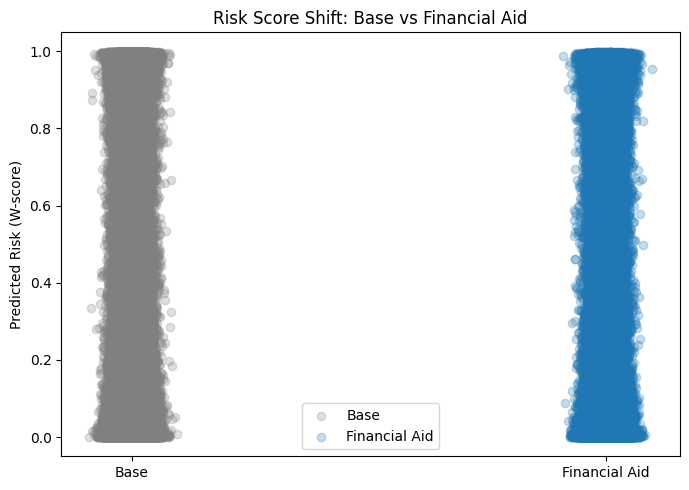

In [26]:
import numpy as np

plt.figure(figsize=(7,5))
# Base
plt.scatter(np.random.normal(1, 0.02, len(train)), train["W_base"],
            alpha=0.25, label="Base", color="gray")
# Financial Aid
plt.scatter(np.random.normal(2, 0.02, len(train)), train["W_fs"],
            alpha=0.25, label="Financial Aid", color="tab:blue")

plt.xticks([1, 2], ["Base", "Financial Aid"])
plt.ylabel("Predicted Risk (W-score)")
plt.title("Risk Score Shift: Base vs Financial Aid")
plt.legend()
plt.tight_layout()
plt.savefig("fig_shift_scatter_fs.png", dpi=150, bbox_inches="tight")
plt.show()


/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


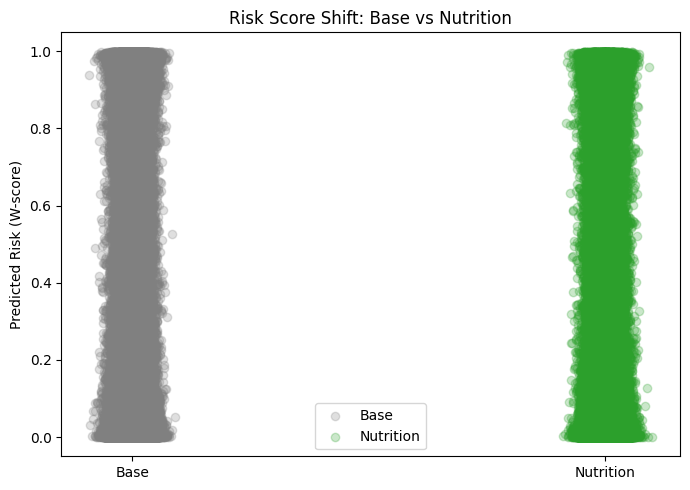

In [27]:
# 예: Nutrition
plt.figure(figsize=(7,5))
plt.scatter(np.random.normal(1, 0.02, len(train)), train["W_base"],
            alpha=0.25, label="Base", color="gray")
plt.scatter(np.random.normal(2, 0.02, len(train)), train["W_nutri"],
            alpha=0.25, label="Nutrition", color="tab:green")

plt.xticks([1, 2], ["Base", "Nutrition"])
plt.ylabel("Predicted Risk (W-score)")
plt.title("Risk Score Shift: Base vs Nutrition")
plt.legend()
plt.tight_layout()
plt.savefig("fig_shift_scatter_nutri.png", dpi=150, bbox_inches="tight")
plt.show()


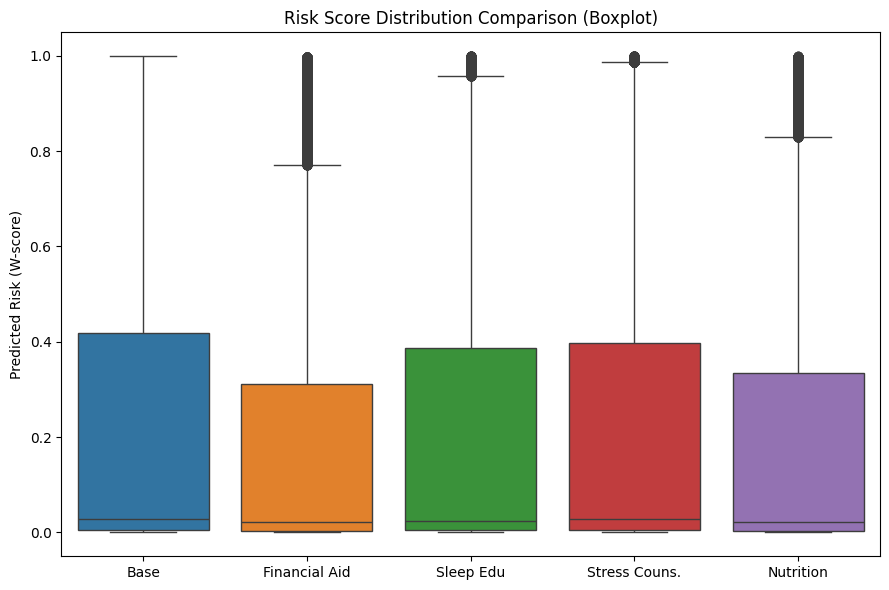

In [28]:
plt.figure(figsize=(9,6))

box_df = pd.DataFrame({
    "Base": train["W_base"],
    "Financial Aid": train["W_fs"],
    "Sleep Edu": train["W_sleep"],
    "Stress Couns.": train["W_stress"],
    "Nutrition": train["W_nutri"],   # ← 여기 W_nutri
})

sns.boxplot(data=box_df)
plt.title("Risk Score Distribution Comparison (Boxplot)")
plt.ylabel("Predicted Risk (W-score)")
plt.tight_layout()
plt.savefig("fig_boxplot_compare.png", dpi=150, bbox_inches="tight")
plt.show()



In [21]:
# 예시: 재정 스트레스 상위 30% vs 나머지 집단 보호효과 비교

pe_fs_high = protection_effect(W_base, W_fs, mask_fs_high)
pe_fs_others = protection_effect(W_base, W_fs, ~mask_fs_high)

pe_group = pd.DataFrame({
    "group": ["High Financial Stress (Top 30%)", "Others"],
    "pe": [pe_fs_high, pe_fs_others],
})
pe_group

,group,pe
0,High Financial Stress (Top 30%),16.481115
1,Others,0.000000


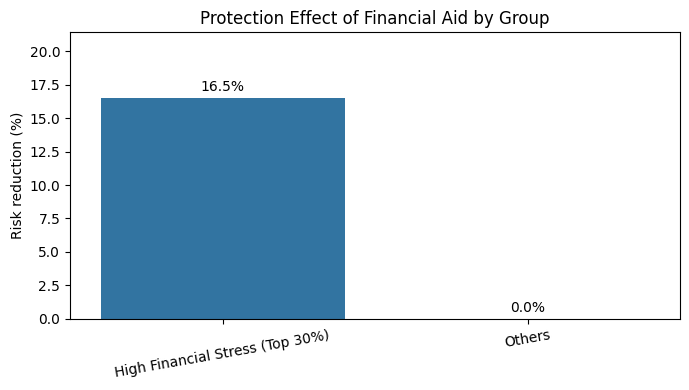

In [22]:
plt.figure(figsize=(7, 4))
sns.barplot(data=pe_group, x="group", y="pe")
plt.ylabel("Risk reduction (%)")
plt.xlabel("")
plt.ylim(0, pe_group["pe"].max() * 1.3)
plt.title("Protection Effect of Financial Aid by Group")
plt.xticks(rotation=10)
for i, v in enumerate(pe_group["pe"]):
    plt.text(i, v + 0.3, f"{v:.1f}%", ha="center", va="bottom")

save_or_show(None, "fig8_pe_by_group_fs.png")

## 9. 결론 요약

- XGBoost 기반 예측 모델을 활용해 학생·직장인 정신건강 위험도를 정량적으로 추정했습니다.  
- **Financial Stress, Sleep Duration, Academic Pressure, Work/Study Hours**가 핵심 위험 요인으로 나타났습니다.  
- 세 가지 개입 시나리오에 대해 **보호효과(Protection Effect)**를 계산한 결과,

  - 장학·재정 지원: 약 12.7% 위험도 감소  
  - 상담·스트레스 완화: 약 4.3% 감소  
  - 수면 교육: 약 3.0% 감소  

- 특히 **재정 스트레스 상위 30% 집단**에 대한 타겟 개입이 가장 큰 효과를 보여,  
  예산 대비 효율적인 정책 설계에 중요한 인사이트를 제공합니다.



최종 모델 학습 (train전체 사용)  --> 학생 모델링으로 진행